In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time

In [3]:
def data_loading(data_path, label_path, batch_size, train_ratio=0.8):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)

    dataset = TensorDataset(data, labels)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [4]:
batch_size = 64
train_loader, test_loader = data_loading(data_path='data.pt', label_path='label.pt',batch_size= batch_size)

In [5]:
X, y = next(iter(train_loader)) # Requests the first training batch
print(X.size()) 
print(y.size())

torch.Size([64, 24, 100])
torch.Size([64])


In [6]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, batch_size):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=24, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(32*91, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [7]:
# Create an instance of the CNN
model = SimpleCNN(batch_size)
lr = 0.004
# Loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.to(device)

SimpleCNN(
  (conv1): Conv1d(24, 32, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2912, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)

In [8]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

In [9]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    j = 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n

## Training


Epoch 1/100.
Training accuracy: 48.9361686706543. Testing accuracy: 54.16666793823242. Duration: 0.372s.

Epoch 2/100.
Training accuracy: 48.9361686706543. Testing accuracy: 54.16666793823242. Duration: 0.031s.

Epoch 3/100.
Training accuracy: 51.0638313293457. Testing accuracy: 45.83333206176758. Duration: 0.007s.

Epoch 4/100.
Training accuracy: 51.0638313293457. Testing accuracy: 45.83333206176758. Duration: 0.020s.

Epoch 5/100.
Training accuracy: 51.0638313293457. Testing accuracy: 45.83333206176758. Duration: 0.013s.

Epoch 6/100.
Training accuracy: 51.0638313293457. Testing accuracy: 45.83333206176758. Duration: 0.014s.

Epoch 7/100.
Training accuracy: 51.0638313293457. Testing accuracy: 45.83333206176758. Duration: 0.013s.

Epoch 8/100.
Training accuracy: 51.0638313293457. Testing accuracy: 45.83333206176758. Duration: 0.013s.

Epoch 9/100.
Training accuracy: 51.0638313293457. Testing accuracy: 45.83333206176758. Duration: 0.014s.

Epoch 10/100.
Training accuracy: 51.063831329

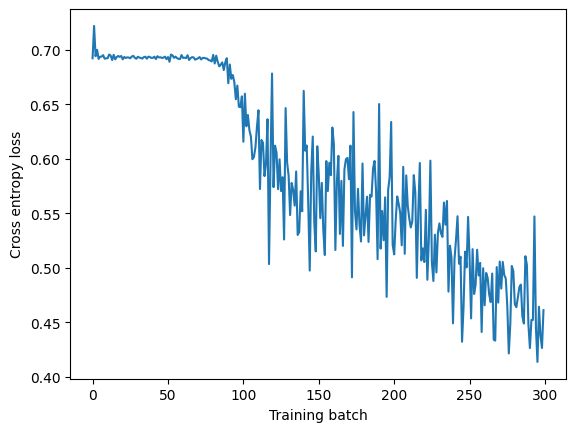

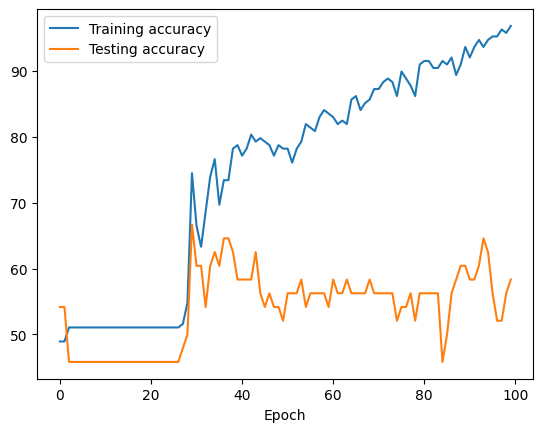

In [10]:
losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 100
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train() # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_loader:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Computes the logits for the batch of images `X`
        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    train_accs.append(evaluate_metric(model, train_loader, correct))
    test_accs.append(evaluate_metric(model, test_loader, correct))

    end_time = time.perf_counter()

    print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()

# Training function
def train(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Move data to the appropriate device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}')


# Evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = outputs.argmax(axis=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%')

# Train the model
train(model, train_loader, criterion, optimizer, epochs=100)

# Evaluate the model
evaluate(model, test_loader, criterion)